<a href="https://colab.research.google.com/github/runningman145/Food-Quality-Assesment/blob/main/Fruit_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Fruit Dataset analysis**
1. Analyzing Class Distribution
2. Applying Noise Reduction
3. Balancing the dataset

In [18]:
import kagglehub
# import necessary libraries
# import zipfile # for working with zipfiles
import os # for operating system related tasks like file and directory
import shutil # for high-level operations, copying and moving files
from collections import Counter # counting frequency of items in a list
import matplotlib.pyplot as plt # for data visualization
import cv2 # opencv for computer vision
import numpy as np
import random # for generating random numbers

In [19]:
# Download latest version
path = kagglehub.dataset_download("moltean/fruits")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/moltean/fruits/versions/11


In [27]:
def analyze_class_distribution(path):
    """Analyzes the class distribution of images in the dataset."""
    class_counts = Counter()

    # Iterate through dictionaries and count images in each class of class_counts
    for root, dirs, files in os.walk(path):
        for dir in dirs:
            class_path = os.path.join(root, dir)
            class_counts[dir] = len([f for f in os.listdir(class_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])

    return class_counts


def plot_distribution(class_counts):
    """Plot the distribution of images across classes."""
    # Get keys and values from the class counts
    classes = list(class_counts.keys())
    counts = list(class_counts.values())

    plt.figure(figsize=(12, 6))
    plt.bar(classes, counts)
    plt.title('Distribution of Images Across Fruit Categories')
    plt.xlabel('Fruit Category')
    plt.ylabel('Number of Images')
    plt.xticks(rotation=90, ha='right')
    plt.tight_layout()
    plt.savefig('class_distribution.png')
    # plt.close()

In [28]:
# Step 2: Noise Reduction

def apply_noise_reduction(image_path, output_path, method='gaussian', kernel_size=5):
    """Apply noise reduction to a single image."""
    # Read the image
    img = cv2.imread(image_path)

    # applying noise reduction, gaussian noise reduction
    if method == 'gaussian':
        denoised = cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)
    elif method == 'median':
        denoised = cv2.medianBlur(img, kernel_size)
    else:
        raise ValueError("Method must be 'gaussian' or 'median'")

    cv2.imwrite(output_path, denoised)

def process_dataset(input_dir, output_dir, method='gaussian', kernel_size=5):
    """Apply noise reduction to all images in the dataset."""
    # Iterate through all files and apply noise reduction
    for root, dirs, files in os.walk(input_dir):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                input_path = os.path.join(root, file)
                relative_path = os.path.relpath(input_path, input_dir)
                output_path = os.path.join(output_dir, relative_path)

                os.makedirs(os.path.dirname(output_path), exist_ok=True)
                apply_noise_reduction(input_path, output_path, method, kernel_size)


In [29]:
# Step 3: Dataset Balancing

def balance_dataset(input_dir, output_dir, target_count=None):
    """
    Balance the dataset by oversampling minority classes.
    arguments:

    """
    class_counts = Counter()

    # Count the images in each class
    for class_name in os.listdir(input_dir):
        class_path = os.path.join(input_dir, class_name)
        if os.path.isdir(class_path):
            class_counts[class_name] = len([f for f in os.listdir(class_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])

    # Determine the target count, the desired number of images per class
    if target_count is None:
        target_count = max(class_counts.values())

    # Balance classes
    for class_name, count in class_counts.items():
        input_class_path = os.path.join(input_dir, class_name)
        output_class_path = os.path.join(output_dir, class_name)
        os.makedirs(output_class_path, exist_ok=True)

        # Copy all original images
        files = [f for f in os.listdir(input_class_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        for file in files:
            shutil.copy2(os.path.join(input_class_path, file), output_class_path)

        # Oversample if necessary
        if count < target_count:
            for i in range(target_count - count):
                file = random.choice(files)
                new_name = f"{os.path.splitext(file)[0]}_copy{i}{os.path.splitext(file)[1]}"
                shutil.copy2(os.path.join(input_class_path, file),
                             os.path.join(output_class_path, new_name))

Analyzing class distribution...

Initial Class Distribution:
fruits-360_dataset_original-size: 0
fruits-360_dataset_100x100: 0
fruits-360-original-size: 0
Training: 0
Validation: 0
Test: 0
Meta: 0
Papers: 0
apple_6: 0
apple_red_delicios_1: 0
apple_granny_smith_1: 0
apple_red_3: 0
zucchini_dark_1: 0
apple_pink_lady_1: 0
carrot_1: 0
cucumber_1: 0
apple_rotten_1: 0
zucchini_1: 0
apple_red_1: 0
pear_1: 0
apple_hit_1: 0
apple_golden_3: 0
apple_crimson_snow_1: 0
cucumber_3: 0
apple_golden_1: 0
pear_3: 0
eggplant_long_1: 0
apple_red_2: 0
cabbage_white_1: 0
apple_braeburn_1: 0
apple_red_yellow_1: 0
apple_golden_2: 0
fruits-360: 0
Apple Red Yellow 2: 219
Pepper Red 1: 222
Potato White 1: 150
Pear Stone 1: 237
Lemon Meyer 1: 166
Rambutan 1: 164
Quince 1: 166
Tomato Maroon 1: 127
Cantaloupe 2: 164
Pitahaya Red 1: 166
Corn Husk 1: 154
Pepper Orange 1: 234
Kohlrabi 1: 157
Pear 2: 232
Ginger Root 1: 99
Cocos 1: 166
Avocado 1: 143
Nectarine 1: 164
Potato Sweet 1: 150
Grapefruit White 1: 164
Pear 3: 7

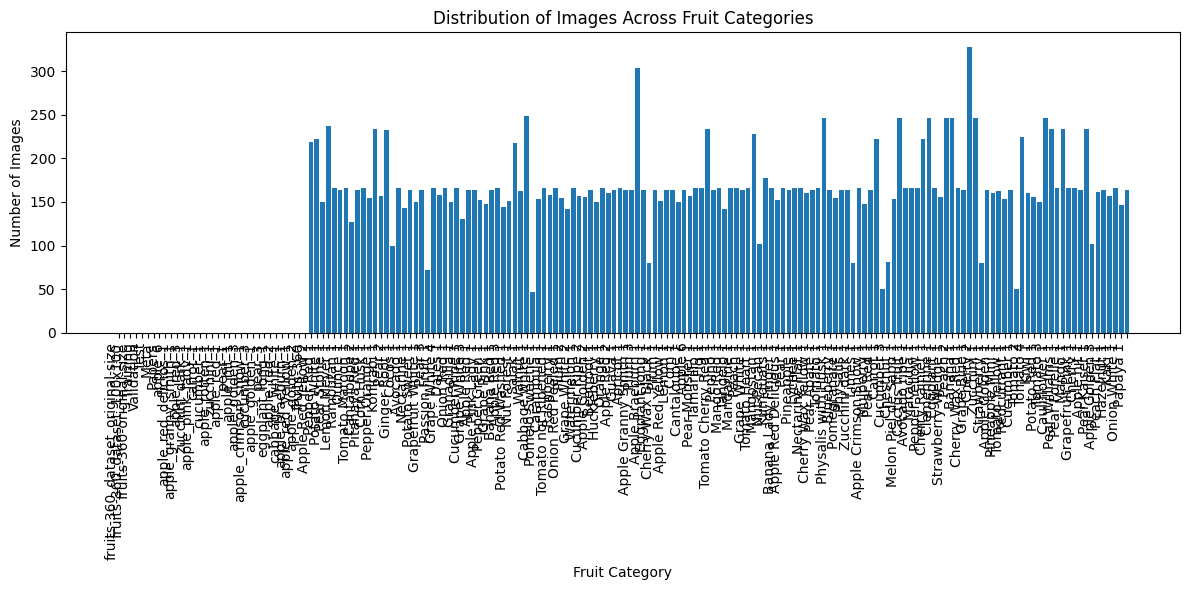

In [30]:
# Main workflow

def main(zip_path):
    # Creating temporary directories
    temp_dir = "temp_extracted_dataset"
    denoised_dir = "temp_denoised_dataset"
    balanced_dir = "balanced_dataset"
    os.makedirs(temp_dir, exist_ok=True)
    os.makedirs(denoised_dir, exist_ok=True)
    os.makedirs(balanced_dir, exist_ok=True)

    try:
        # Step 1: Analyze

        print("Analyzing class distribution...")
        class_counts = analyze_class_distribution(path)

        print("\nInitial Class Distribution:")
        for class_name, count in class_counts.items():
            print(f"{class_name}: {count}")

        plot_distribution(class_counts)
        print("Initial distribution plot saved as 'class_distribution.png'")

        # Step 2: Noise Reduction
        print("\nApplying noise reduction...")
        process_dataset(path, denoised_dir, method='gaussian', kernel_size=5)

        # Step 3: Balance Dataset
        print("\nBalancing dataset...")
        balance_dataset(denoised_dir, balanced_dir)

        # Analyze final distribution
        final_class_counts = analyze_class_distribution(balanced_dir)
        print("\nFinal Class Distribution:")
        for class_name, count in final_class_counts.items():
            print(f"{class_name}: {count}")

        # plot_distribution(final_class_counts)

    finally:
        # Clean up temporary directories
        print("\nCleaning up temporary files...")
        shutil.rmtree(temp_dir)
        shutil.rmtree(denoised_dir)

    print(f"\nProcessing complete. Balanced dataset saved in '{balanced_dir}'")

if __name__ == "__main__":
    # path = "/root/.cache/kagglehub/datasets/moltean/fruits/versions/11"
    main(path)
